<a href="https://colab.research.google.com/github/earth-obs/lake-gee-hydrology-water-quality/blob/main/lake-gee-hydrology-water-quality.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#########################################################################
# Assessing long-term hydrological dynamics and water quality           #
# using Google Earth Engine: A case study of Ilgın Lake (1985-2024)     #
#																		                                    #
#	Omer Faruk Atiz (c) 01.03.2025										                    #
#	oatiz@erbakan.edu.tr                                                  #
#	Necmettin Erbakan University, Geomatics Engineering					          #
#                                                                       #
# Citation:                                                             #
#                                                                       #
#########################################################################

In [1]:
#########################################################################
# Import Earth Engine
import ee
import geemap
ee.Authenticate()
ee.Initialize(project='ee-eelabneu') #your-project-id
import eerepr
eerepr.initialize()

# Import other libraries
!pip install pymannkendall scipy pingouin
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import linregress, pearsonr
import statsmodels.api as sm
import pymannkendall as mk
import pingouin as pg
from tabulate import tabulate
#########################################################################

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.4/204.4 kB 6.7 MB/s eta 0:00:00


In [2]:
# Select your region of interest by filtering HydroAtlas database
# lake_poly = ee.FeatureCollection("projects/sat-io/open-datasets/HydroAtlas/LakeAtlas/LakeAtlas_v10_polygon")
# roi_feature = lake_poly.filter(ee.Filter.eq('Hylak_id', 14698)).first()
# roi = roi_feature.geometry()
# or Manually give boundaries

roi = ee.Geometry.Polygon(
        [[[31.8347, 38.3991],
          [31.8347, 38.3032],
          [31.9171, 38.3032],
          [31.9171, 38.3991]]])

In [3]:
START_YEAR = 1985
END_YEAR = 2024
START_MONTH = 1
END_MONTH = 12
ALLOWED_MAX_CLOUD_COVER = 20

In [4]:
"""
Bit 0: Fill
  0: Image data
  1: Fill data
Bit 2: Cirrus
  0: Cirrus Confidence: no confidence level set or Low Confidence
  1: High confidence cirrus
Bit 3: Cloud
  0: Cloud confidence is not high
  1: High confidence cloud
Bit 4: Cloud Shadow
  0: Cloud Shadow Confidence is not high
  1: High confidence cloud shadow
Bit 5: Snow
  0: Snow/Ice Confidence is not high
  1: High confidence snow cover
"""
def qa_mask_tm_etm(image):
  qa = image.select('QA_PIXEL')
  mask = qa.bitwiseAnd(1 << 0).eq(0) \
    .And(qa.bitwiseAnd(1 << 3).eq(0)) \
    .And(qa.bitwiseAnd(1 << 4).eq(0)) \
    .And(qa.bitwiseAnd(1 << 5).eq(0))
  return image.updateMask(mask)

def qa_mask_oli(image):
  qa = image.select('QA_PIXEL')
  mask = qa.bitwiseAnd(1 << 0).eq(0) \
    .And(qa.bitwiseAnd(1 << 2).eq(0)) \
    .And(qa.bitwiseAnd(1 << 3).eq(0)) \
    .And(qa.bitwiseAnd(1 << 4).eq(0)) \
    .And(qa.bitwiseAnd(1 << 5).eq(0))
  return image.updateMask(mask)

def fillETM(image):
  img_fill = image.focal_mean(1, 'square', 'pixels', 8)
  return img_fill.blend(image).copyProperties(image, image.propertyNames())

"""
The functions for Dynamic thrsholding with Otsu method
"""
def make_historgram(image):
  histogram = image.reduceRegion(**{
    'reducer': ee.Reducer.histogram(255),
    'geometry': roi,
    'scale': 30,
    'bestEffort': True
    })
  return image.set('histogram', histogram.get('MNDWI'))

def otsu_thres(image):
  histogram = image.get('histogram')
  counts = ee.Array(ee.Dictionary(histogram).get('histogram'))
  means = ee.Array(ee.Dictionary(histogram).get('bucketMeans'))

  total = counts.reduce(ee.Reducer.sum(), [0]).get([0])
  sum = means.multiply(counts).reduce(ee.Reducer.sum(), [0]).get([0])
  mean = sum.divide(total)

  def func_bss(i):
    aCounts = counts.slice(0, 0, i)
    aCount = aCounts.reduce(ee.Reducer.sum(), [0]).get([0])
    aMeans = means.slice(0, 0, i)
    aMean = aMeans.multiply(aCounts).reduce(ee.Reducer.sum(), [0]).get([0]).divide(aCount)
    bCount = total.subtract(aCount)
    bMean = sum.subtract(aCount.multiply(aMean)).divide(bCount)
    return aCount.multiply(aMean.subtract(mean).pow(2)).add(bCount.multiply(bMean.subtract(mean).pow(2)))

  bss = ee.List.sequence(1, means.length().get([0])).map(func_bss)
  threshold = means.sort(bss).get([-1])

  return image.set('threshold', threshold)

def calculate_water_area(image):
  """
  Calculates water area in hectare unit.
  If you want different units eg. km^2 change .divide(1e4) to 1e6
  """
  threshold = ee.Number(image.get('threshold'))
  water_mask = image.select('MNDWI').gt(threshold)
  area = water_mask.multiply(ee.Image.pixelArea().divide(1e4)).reduceRegion(**{
    'reducer': ee.Reducer.sum(),
    'geometry': roi,
    'scale': 30
    }).get('MNDWI')

  return image.set('water_area', area)

def create_water_mask(image):
  """
  Classifies MNDWI into 1: water, 0: non-water and masks other than water
  """
  threshold = ee.Number(image.get('threshold'))
  water_mask = image.select('MNDWI').gt(threshold)

  return water_mask.copyProperties(image, image.propertyNames())

def export_image_collection(coll, descriptions):
  """
  The wrapped geemap export image collection to drive function to set output folder, crs etc.

  Input:
    image (ee.ImageCollection): ImageCollection to be exported
    descriptions (list): The list of descriptions of images to pass filename and GEE task name
  Output:
    ee.batch.Task: Earth Engine export task that automatically starts
  Note:
    The status of export tasks can be seen at GEE Task Manager
    (code.earthengine.google.com/tasks) or Cloud Console Tasks
    page (console.cloud.google.com/earth-engine/tasks)
  """
  geemap.ee_export_image_collection_to_drive(
    ee_object = coll,
    folder = 'foss4ge_results',
    descriptions = descriptions,
    region = roi,
    scale = 30
    # scale = 30,  # optional crs can be selected
    # crs = 'EPSG:5255'
    )

In [5]:
# Long term annual Landsat 5/7/8 composites
# Variable 1: Annual Median MNDWI (Xu, 2006)
# Variable 2: Annual Median NDTI (Lacaux et al, 2007)
# Variable 3: Annual Median NDCI (Mishra and Mishra, 2012)
# Unit: Range [-1, +1]

l5_coll = (ee.ImageCollection('LANDSAT/LT05/C02/T1_TOA')
  .filter(ee.Filter.calendarRange(START_MONTH, END_MONTH, 'month'))
  .filterDate('1985-01-01', '2011-12-31')
  .filter(ee.Filter.eq('WRS_PATH', 178))
  .filter(ee.Filter.eq('WRS_ROW', 33))
  .filter(ee.Filter.lte('CLOUD_COVER', ALLOWED_MAX_CLOUD_COVER))
  .select(['B1', 'B2', 'B3', 'B4', 'B5', 'QA_PIXEL'], ['Blue', 'Green', 'Red', 'NIR', 'SWIR1', 'QA_PIXEL']) # select B2 and B4 as green and nir
  .map(qa_mask_tm_etm))

l7_coll = (ee.ImageCollection('LANDSAT/LE07/C02/T1_TOA')
  .filter(ee.Filter.calendarRange(START_MONTH, END_MONTH, 'month'))
  .filterDate('2012-01-01', '2012-12-31')
  .filter(ee.Filter.eq('WRS_PATH', 178))
  .filter(ee.Filter.eq('WRS_ROW', 33))
  .filter(ee.Filter.lte('CLOUD_COVER', ALLOWED_MAX_CLOUD_COVER))
  .select(['B1', 'B2', 'B3', 'B4', 'B5', 'QA_PIXEL'], ['Blue', 'Green', 'Red', 'NIR', 'SWIR1', 'QA_PIXEL']) # select B2 and B4 as green and nir
  .map(qa_mask_tm_etm)
  .map(fillETM))

l8_coll = (ee.ImageCollection('LANDSAT/LC08/C02/T1_TOA')
  .filter(ee.Filter.calendarRange(START_MONTH, END_MONTH, 'month'))
  .filterDate('2013-01-01', '2024-12-31')
  .filter(ee.Filter.eq('WRS_PATH', 178))
  .filter(ee.Filter.eq('WRS_ROW', 33))
  .filter(ee.Filter.lte('CLOUD_COVER', ALLOWED_MAX_CLOUD_COVER))
  .select(['B2', 'B3', 'B4', 'B5', 'B6', 'QA_PIXEL'], ['Blue', 'Green', 'Red', 'NIR', 'SWIR1', 'QA_PIXEL']) # select L8 Oli B3 and B5 as green and nir
  .map(qa_mask_oli))

landsat_coll = ee.ImageCollection(l5_coll.merge(l7_coll.merge(l8_coll)))

def create_annual_composites(year):
  median_image = landsat_coll.filter(ee.Filter.calendarRange(year, year, 'year')).select(['Blue', 'Green', 'Red', 'NIR', 'SWIR1']).median()
  return median_image.clip(roi).set({'system:time_start': ee.Date.fromYMD(year, 1, 1).millis(),
    'year': year})

median_coll = ee.ImageCollection.fromImages(ee.List.sequence(START_YEAR, END_YEAR).map(create_annual_composites))

def compute_mndwi(year):
  median_image = median_coll.filter(ee.Filter.calendarRange(year, year, 'year')).select(['Green', 'SWIR1']).first()
  mndwi = median_image.normalizedDifference(['Green', 'SWIR1']).rename('MNDWI') #mNDWI
  return mndwi.set({'system:time_start': ee.Date.fromYMD(year, 1, 1).millis(),
    'year': year})
mndwi_coll = ee.ImageCollection.fromImages(ee.List.sequence(START_YEAR, END_YEAR).map(compute_mndwi))
mndwi_area = mndwi_coll.map(make_historgram).map(otsu_thres).map(calculate_water_area)
mndwi_water = mndwi_coll.map(make_historgram).map(otsu_thres).map(create_water_mask)

# to print water areas use below
# mndwi_area.aggregate_array('water_area')

def compute_ndti(year):
  median_image = median_coll.filter(ee.Filter.calendarRange(year, year, 'year')).select(['Red', 'Green']).first()
  ndti = median_image.normalizedDifference(['Red', 'Green']).rename('NDTI') #NDTI
  return ndti.set({'system:time_start': ee.Date.fromYMD(year, 1, 1).millis(),
    'year': year})
ndti_coll = ee.ImageCollection.fromImages(ee.List.sequence(START_YEAR, END_YEAR).map(compute_ndti))

def compute_ndci(year):
  median_image = median_coll.filter(ee.Filter.calendarRange(year, year, 'year')).select(['NIR', 'Red']).first()
  ndci = median_image.normalizedDifference(['NIR', 'Red']).rename('NDCI') #NDCI
  return ndci.set({'system:time_start': ee.Date.fromYMD(year, 1, 1).millis(),
    'year': year})

ndci_coll = ee.ImageCollection.fromImages(ee.List.sequence(START_YEAR, END_YEAR).map(compute_ndci))

join = ee.Join.inner()
filter = ee.Filter.equals(
    leftField='year',
    rightField='year'
)
joined_ndti = join.apply(
    primary=ndti_coll,
    secondary=mndwi_water,
    condition=filter
)

joined_ndci = join.apply(
    primary=ndci_coll,
    secondary=mndwi_water,
    condition=filter
)

def apply_water_mask(feature):
  primary = ee.Image(feature.get('primary'))
  mask = ee.Image(feature.get('secondary'))

  return primary.updateMask(mask)

water_masked_ndti = ee.ImageCollection(joined_ndti.map(apply_water_mask))
water_masked_ndci = ee.ImageCollection(joined_ndci.map(apply_water_mask))

In [6]:
landsat_coll.size()

In [7]:
# Long term annual ERA5 precipitations
# Variable: Annual Total Prec
# Unit: mm
era5_prec = (ee.ImageCollection('ECMWF/ERA5_LAND/MONTHLY_AGGR')
  .filter(ee.Filter.calendarRange(START_MONTH, END_MONTH, 'month'))
  .select('total_precipitation_sum'))

def prec_composite(year):
  img = era5_prec.filter(ee.Filter.calendarRange(year, year, 'year')).sum().multiply(1000) \
    .set({'system:time_start': ee.Date.fromYMD(year, 1, 1).millis(),
    'year': year})
  return img.clip(roi)

prec_coll = ee.ImageCollection.fromImages(ee.List.sequence(START_YEAR, END_YEAR).map(prec_composite))

In [8]:
# Long term annual ERA5 Temperature
# Variable: Annual Mean Temperature
# Unit: Celcius degree
era5_temp = (ee.ImageCollection('ECMWF/ERA5_LAND/MONTHLY_AGGR')
  .filter(ee.Filter.calendarRange(START_MONTH, END_MONTH, 'month'))
  .select('temperature_2m'))

def temp_composite(year):
  img = era5_temp.filter(ee.Filter.calendarRange(year, year, 'year')).mean().subtract(273.15) \
    .set({'system:time_start': ee.Date.fromYMD(year, 1, 1).millis(),
    'year': year})
  return img.clip(roi)

temp_coll = ee.ImageCollection.fromImages(ee.List.sequence(START_YEAR, END_YEAR).map(temp_composite))

In [9]:
def calculate_era5_mean(band_name):
  def wrap_image(image):
    mean_value = image.reduceRegion(
      reducer = ee.Reducer.mean(),
      geometry = roi,
      scale = 11132
      ).get(band_name)
    return image.set('mean_value', mean_value)
  return wrap_image

prec_coll_mean = prec_coll.map(calculate_era5_mean('total_precipitation_sum'))
prec_list = prec_coll_mean.aggregate_array('mean_value').getInfo()
water_prec = np.array(prec_list)

temp_coll_mean = temp_coll.map(calculate_era5_mean('temperature_2m'))
temp_list = temp_coll_mean.aggregate_array('mean_value').getInfo()
water_temp = np.array(temp_list)

In [10]:
def calculate_landsat_mean(band_name):
  def wrap_image(image):
    imageMasked = image.updateMask(image.gt(0)) # Mask values lower than zero
    mean_value = imageMasked.reduceRegion(
      reducer = ee.Reducer.mean(),
      geometry = roi,
      scale = 30
      ).get(band_name)
    return image.set('mean_value', mean_value)
  return wrap_image

ndti_coll_mean = water_masked_ndti.map(calculate_landsat_mean('NDTI'))
ndti_list = ndti_coll_mean.aggregate_array('mean_value').getInfo()
water_ndti = np.array(ndti_list)

ndci_coll_mean = water_masked_ndci.map(calculate_landsat_mean('NDCI'))
ndci_list = ndci_coll_mean.aggregate_array('mean_value').getInfo()
water_ndci = np.array(ndci_list)

In [ ]:
vis_year = 2024

Map = geemap.Map()

Map.addLayer(median_coll.filter(ee.Filter.eq('year', vis_year)).select(['Red', 'Green', 'Blue']), {'min': 0, 'max': 0.4}, 'Landsat TrueColor321')
Map.addLayer(mndwi_coll.filter(ee.Filter.eq('year', vis_year)), {'min': -1, 'max': 1, 'palette': ['white', 'blue']}, 'MNDWI', False)
Map.addLayer(mndwi_water.filter(ee.Filter.eq('year', vis_year)), {'min': 0, 'max': 1, 'palette': ['white', 'black']}, 'Water Mask', False)
Map.addLayer(water_masked_ndti.filter(ee.Filter.eq('year', vis_year)), {'min': -1, 'max': 1, 'palette': ['blue', 'green', 'yellow', 'orange', 'red']}, 'NDTI Masked', False)
Map.addLayer(water_masked_ndti.filter(ee.Filter.eq('year', vis_year)).first().gt(0.2), {'min': 0, 'max': 1, 'palette': ['white', 'red']}, 'High Turbidity > 0.2', False)
Map.addLayer(water_masked_ndci.filter(ee.Filter.eq('year', vis_year)), {'min': -1, 'max': 1, 'palette': ['blue', 'green', 'yellow', 'orange', 'red']}, 'NDCI Masked', False)
Map.addLayer(water_masked_ndci.filter(ee.Filter.eq('year', vis_year)).first().gt(0.3), {'min': 0, 'max': 1, 'palette': ['white', 'green']}, 'High Chl-a > 0.3', False)

Map.centerObject(roi, 12)
Map

Map(center=[38.35114662458292, 31.875900000001742], controls=(WidgetControl(options=['position', 'transparent_…

In [11]:
# Pull area list from earth engine to client-side
water_area_list = mndwi_area.aggregate_array('water_area').getInfo()
water_thrs_list = mndwi_area.aggregate_array('threshold').getInfo()
years = list(range(START_YEAR, END_YEAR + 1))

water_area = np.array(water_area_list)
water_thrs = np.array(water_thrs_list)
years = np.array(years)

print(f'Data Length: {len(water_area)} years')

Data Length: 40 years


In [12]:
water_area_list

[2306.5930699341375,
 1757.7573330444854,
 1792.5663181946322,
 2477.6846090881772,
 2030.5122153992438,
 1802.638155755668,
 1851.3982145996727,
 2362.6121865234845,
 2054.25890742196,
 1549.254054583795,
 2037.7782800904117,
 2627.783536444149,
 2557.6694156310996,
 2321.0453991699565,
 2290.815867657523,
 1976.6802726807182,
 1838.2181245667005,
 2460.253910040314,
 2460.5576648010656,
 2374.097681781046,
 1699.7677043763038,
 1599.5699025086194,
 1719.525422503716,
 1580.47127871711,
 1932.7846896851,
 2089.9136882691328,
 2203.975942358453,
 2324.841330950978,
 2270.637338665877,
 1537.1285093628483,
 2522.828926928721,
 2043.0431265320437,
 1698.4975670594115,
 1437.1859206421343,
 1558.3396398926377,
 1786.09672730109,
 1504.5678181152743,
 1920.5155558289082,
 1957.2271986999938,
 1593.5764875733128]

In [13]:
# Mann-Kendall/Theil Sen slope
ndwi_result = mk.original_test(water_area)
prec_result = mk.original_test(water_prec)
temp_result = mk.original_test(water_temp)
ndti_result = mk.original_test(water_ndti)
ndci_result = mk.original_test(water_ndci)

data = [
    ["Water Area", ndwi_result.trend, f"{ndwi_result.slope}", f"{ndwi_result.p}", f"{ndwi_result.z}", f"{1 - ndwi_result.p:.1%}"],
    ["Precipitation", prec_result.trend, f"{prec_result.slope}", f"{prec_result.p}", f"{prec_result.z}", f"{1 - prec_result.p:.1%}"],
    ["Temperature", temp_result.trend, f"{temp_result.slope}", f"{temp_result.p}", f"{temp_result.z}", f"{1 - temp_result.p:.1%}"],
    ["Turbidity", ndti_result.trend, f"{ndti_result.slope}", f"{ndti_result.p}", f"{ndti_result.z}", f"{1 - ndti_result.p:.1%}"],
    ["Chlorophyll-a", ndci_result.trend, f"{ndci_result.slope}", f"{ndci_result.p}", f"{ndci_result.z}", f"{1 - ndci_result.p:.1%}"]
]

headers = ["Parameter", "Trend", "Sens Slope", "P-Value", "Z-Score", "Confidence"]

print(tabulate(data, headers=headers, tablefmt="simple", floatfmt=".4f"))


Parameter      Trend         Sens Slope    P-Value    Z-Score  Confidence
-------------  ----------  ------------  ---------  ---------  ------------
Water Area     decreasing       -9.5392     0.0463    -1.9923  95.4%
Precipitation  no trend         -0.2121     0.8067    -0.2447  19.3%
Temperature    increasing        0.0528     0.0000     4.3924  100.0%
Turbidity      no trend          0.0000     0.5840     0.5476  41.6%
Chlorophyll-a  increasing        0.0028     0.0000     4.7886  100.0%


In [14]:
df = pd.DataFrame({
  'year': years,
  'water_area': water_area,
  'water_prec': water_prec,
  'water_temp': water_temp,
  'water_ndti': water_ndti,
  'water_ndci': water_ndci
  }).set_index('year')

# show
print(df.head())

       water_area  water_prec  water_temp  water_ndti  water_ndci
year                                                             
1985  2306.593070  438.268259    9.690461    0.016064    0.039060
1986  1757.757333  297.179083   10.494828    0.011148    0.026681
1987  1792.566318  450.709464    9.555322    0.015670    0.037288
1988  2477.684609  480.492698    9.842445    0.016133    0.095195
1989  2030.512215  303.980186   10.191186    0.012377    0.054558


In [15]:
# Calculate Pearson correlation matrix
corr_matrix = df[['water_area', 'water_prec', 'water_temp', 'water_ndti', 'water_ndci']].corr(method='pearson')

print(tabulate(corr_matrix, headers='keys', tablefmt='simple_grid', floatfmt='.4f'))

┌────────────┬──────────────┬──────────────┬──────────────┬──────────────┬──────────────┐
│            │   water_area │   water_prec │   water_temp │   water_ndti │   water_ndci │
├────────────┼──────────────┼──────────────┼──────────────┼──────────────┼──────────────┤
│ water_area │       1.0000 │       0.1309 │      -0.4466 │       0.0460 │      -0.1170 │
├────────────┼──────────────┼──────────────┼──────────────┼──────────────┼──────────────┤
│ water_prec │       0.1309 │       1.0000 │      -0.0402 │       0.1208 │       0.0818 │
├────────────┼──────────────┼──────────────┼──────────────┼──────────────┼──────────────┤
│ water_temp │      -0.4466 │      -0.0402 │       1.0000 │       0.1021 │       0.3958 │
├────────────┼──────────────┼──────────────┼──────────────┼──────────────┼──────────────┤
│ water_ndti │       0.0460 │       0.1208 │       0.1021 │       1.0000 │       0.2671 │
├────────────┼──────────────┼──────────────┼──────────────┼──────────────┼──────────────┤
│ water_nd

In [16]:
# Exploring lagged effects
# 1 year lagged precipitation effect
df['prec_lag1'] = df['water_prec'].shift(1)
# Area-Prec Lagged Correlation
r_lag1, p_lag1 = pearsonr(df['prec_lag1'].dropna(), df['water_area'].iloc[1:])
print(f"1-year lagged correlation with Prec: {r_lag1:.2f} (p={p_lag1:.4f})")

# 1 year lagged temperature effect
df['temp_lag1'] = df['water_temp'].shift(1)
# Area-Temp Lagged Correlation
r_lag1, p_lag1 = pearsonr(df['temp_lag1'].dropna(), df['water_area'].iloc[1:])
print(f"1-year lagged correlation with Temp: {r_lag1:.2f} (p={p_lag1:.4f})")

# EXample output
# 1-year lagged correlation with WaterArea-Prec: 0.34 (p=0.0327)
# 1-year lagged correlation with WaterArea-Temp: -0.22 (p=0.1747)

1-year lagged correlation with Prec: 0.34 (p=0.0327)
1-year lagged correlation with Temp: -0.22 (p=0.1747)


In [17]:
# Partial Correlation Coefficient (PCC) Analysis

# PCC for WaterArea-Temp (controlling the effect of Prec)
partial_corr_temp = pg.partial_corr(data=df, x='water_temp', y='water_area', covar='water_prec')
# PCC for WaterArea-Prec (controlling the effect of Temp)
partial_corr_prec = pg.partial_corr(data=df, x='water_prec', y='water_area', covar='water_temp')
# PCC for WaterArea-Prec(Lagged-1yr) (controlling the effect of Temp)
partial_corr_prec_lagged_1 = pg.partial_corr(data=df, x='prec_lag1', y='water_area', covar='water_temp')

# PCC for NDCI-Temp (controlling the effect of Prec)
partial_corr_temp_ndci = pg.partial_corr(data=df, x='water_temp', y='water_ndci', covar='water_prec')
# PCC for NDCI-Prec (controlling the effect of Temp)
partial_corr_prec_ndci = pg.partial_corr(data=df, x='water_prec', y='water_ndci', covar='water_temp')
# PCC for NDCI-Prec(Lagged-1yr) (controlling the effect of Temp)
partial_corr_prec_lagged_1_ndci = pg.partial_corr(data=df, x='prec_lag1', y='water_ndci', covar='water_temp')

# PCC results for water area
headers = ["Comparison", "r", "CI95%", "p-val", "n"]

table_data_area = [
    ["Area-Temp",
     partial_corr_temp["r"].values[0],
     partial_corr_temp["CI95%"].values[0],
     partial_corr_temp["p-val"].values[0],
     partial_corr_temp["n"].values[0]],

    ["Area-Prec",
     partial_corr_prec["r"].values[0],
     partial_corr_prec["CI95%"].values[0],
     partial_corr_prec["p-val"].values[0],
     partial_corr_prec["n"].values[0]],

    ["Area-Prec Lagged-1",
     partial_corr_prec_lagged_1["r"].values[0],
     partial_corr_prec_lagged_1["CI95%"].values[0],
     partial_corr_prec_lagged_1["p-val"].values[0],
     partial_corr_prec_lagged_1["n"].values[0]]
]

print("=== Partial Correlation Coefficient (PCC) Analysis for Area/NDCI-Climate ===\n")
print(tabulate(table_data_area, headers=headers, tablefmt='simple', floatfmt='.4f'))


# PCC results for NDCI
table_data_ndci = [
    ["NDCI-Temp",
     partial_corr_temp_ndci["r"].values[0],
     partial_corr_temp_ndci["CI95%"].values[0],
     partial_corr_temp_ndci["p-val"].values[0],
     partial_corr_temp_ndci["n"].values[0]],

    ["NDCI-Prec",
     partial_corr_prec_ndci["r"].values[0],
     partial_corr_prec_ndci["CI95%"].values[0],
     partial_corr_prec_ndci["p-val"].values[0],
     partial_corr_prec_ndci["n"].values[0]],

    ["NDCI-Prec Lagged-1",
     partial_corr_prec_lagged_1_ndci["r"].values[0],
     partial_corr_prec_lagged_1_ndci["CI95%"].values[0],
     partial_corr_prec_lagged_1_ndci["p-val"].values[0],
     partial_corr_prec_lagged_1_ndci["n"].values[0]]
]

# print("\n=== Partial Correlation Coefficient (PCC) Analysis for NDCI-Climate ===")
print(tabulate(table_data_ndci, tablefmt='simple', floatfmt='.4f'))


=== Partial Correlation Coefficient (PCC) Analysis for Area/NDCI-Climate ===

Comparison                r  CI95%            p-val        n
------------------  -------  -------------  -------  -------
Area-Temp           -0.4455  [-0.67 -0.15]   0.0045  40.0000
Area-Prec            0.1263  [-0.2   0.42]   0.4436  40.0000
Area-Prec Lagged-1   0.4351  [0.13 0.66]     0.0063  39.0000
------------------  ------  -------------  ------  -------
NDCI-Temp           0.4007  [0.1  0.64]    0.0115  40.0000
NDCI-Prec           0.1065  [-0.22  0.41]  0.5187  40.0000
NDCI-Prec Lagged-1  0.1696  [-0.16  0.46]  0.3086  39.0000
------------------  ------  -------------  ------  -------


In [18]:
# Ordinary Linear Regression

# Independent variables: Temperature + Precipitation
# Dependent variable: Water Area

X = df[['water_temp', 'water_prec']]
X = sm.add_constant(X)  # Constant term
y = df['water_area']

model = sm.OLS(y, X).fit()
# print(model.summary())
print(f"R²: {model.rsquared:.2f}")
# Example output
# R²: 0.21

R²: 0.21


In [19]:
# Re-run OLS with 1 Year Lagged Prec
# Since we remove the first year align the data
df_clean = df.dropna(subset=['water_temp', 'prec_lag1', 'water_area']).copy()

# Cleaned model and new Ordinary Least Squares
X = df_clean[['water_temp', 'prec_lag1']]
X = sm.add_constant(X)
y = df_clean['water_area']

model_lag = sm.OLS(y, X).fit()
print(f"Prec 1-yr Lagged R²: {model_lag.rsquared:.2f}")
print(model_lag.summary())

Prec 1-yr Lagged R²: 0.34
                            OLS Regression Results                            
Dep. Variable:             water_area   R-squared:                       0.342
Model:                            OLS   Adj. R-squared:                  0.305
Method:                 Least Squares   F-statistic:                     9.357
Date:                Sun, 09 Mar 2025   Prob (F-statistic):           0.000534
Time:                        19:13:09   Log-Likelihood:                -274.49
No. Observations:                  39   AIC:                             555.0
Df Residuals:                      36   BIC:                             560.0
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2823.1699    5

In [ ]:
# # Batch Export mndwi_water collection
# CAUTION: Executing this part of code sent export request from GEE server
# Therefore use with CAUTION! The status of export tasks can be seen at
# GEE Task Manager (code.earthengine.google.com/tasks) or Cloud Console
# Tasks page (console.cloud.google.com/earth-engine/tasks)
# Tasks are exported to Google Drive folder indicated in export function

# mndwi_water_list = mndwi_water.aggregate_array('year').getInfo()
# mndwi_water_list_description = [f'mndwi_water_{year}' for year in mndwi_water_list]
# print(mndwi_water_list_description)
# export_image_collection(mndwi_water, mndwi_water_list_description)

# # Batch Export mndwi_coll collection
# mndwi_coll_list = mndwi_coll.aggregate_array('year').getInfo()
# mndwi_coll_list_description = [f'mndwi_coll_{year}' for year in mndwi_coll_list]
# print(mndwi_coll_list_description)
# export_image_collection(mndwi_coll, mndwi_coll_list_description)

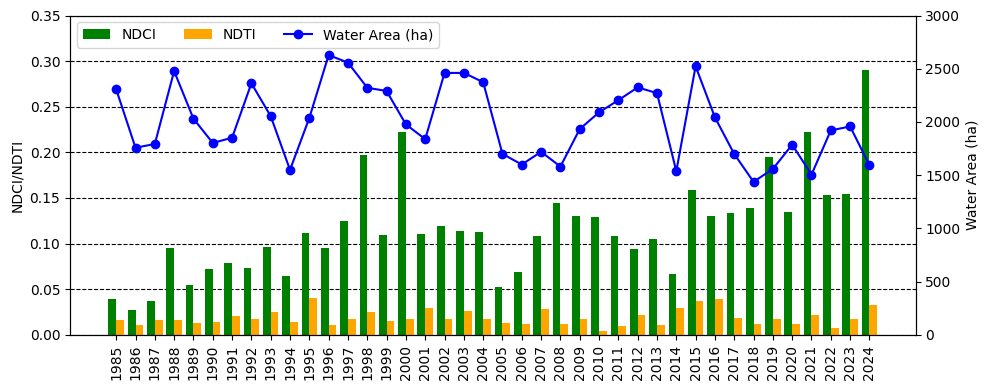

In [ ]:
# Figure: Annual Water Area, NDCI, NDTI variations

plt.figure(figsize=(10, 4))
# NDCI/NDTI
width = 0.4
ax1 = plt.gca()
ax1.grid(axis='y', color='black', linestyle='--', zorder=0)
ax1.bar(np.array(years) - width/2, water_ndci, width, color='green', label='NDCI', zorder=2)
ax1.bar(np.array(years) + width/2, water_ndti, width, color='orange', label='NDTI', zorder=2)
ax1.set_ylabel('NDCI/NDTI', color='black')
ax1.set_ylim(top=0.35)
ax1.tick_params(axis='y', labelcolor='black')
ax1.set_xticks(years)
ax1.set_xticklabels(years, rotation=90, ha='center')

# Water Area
ax2 = ax1.twinx()
ax2.plot(years, water_area, 'o-', color='blue', label='Water Area (ha)')
ax2.set_xlabel('Year')
ax2.set_ylabel('Water Area (ha)')
ax2.set_ylim(bottom=0, top=3000)
ax2.tick_params(axis='y')

# Trend Line
# slope, intercept = linregress(years, water_area)[0:2]
# ax2.plot(years, intercept + slope*np.array(years), 'r--', label=f'Trend: {slope:.2f} ha/year')

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left', ncol=4)

plt.tight_layout()
plt.savefig('Annual_Water_Area_NDCI_NDTI.jpg', dpi=300, bbox_inches='tight')
plt.show()

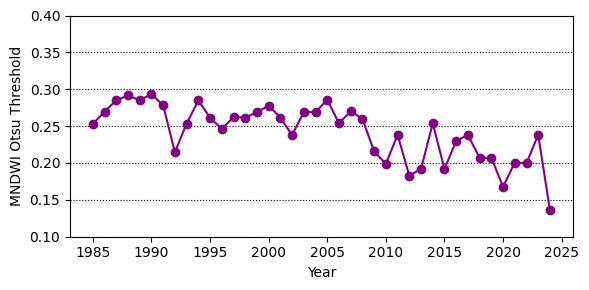

In [ ]:
# Figure: Annual MNDWI Otsu Threshold variations
plt.figure(figsize=(6, 3))
plt.plot(years, water_thrs, 'o-', linestyle='-', color='purple')
# plt.title('Annual Water Threshold Variation')
plt.xlabel('Year')
plt.ylabel('MNDWI Otsu Threshold')
plt.ylim(bottom=0.1, top=0.4)
plt.grid(True, axis='y', linestyle=':', color='black')

plt.tight_layout()
plt.savefig('Annual Water Threshold.jpg', dpi=300)
plt.show()

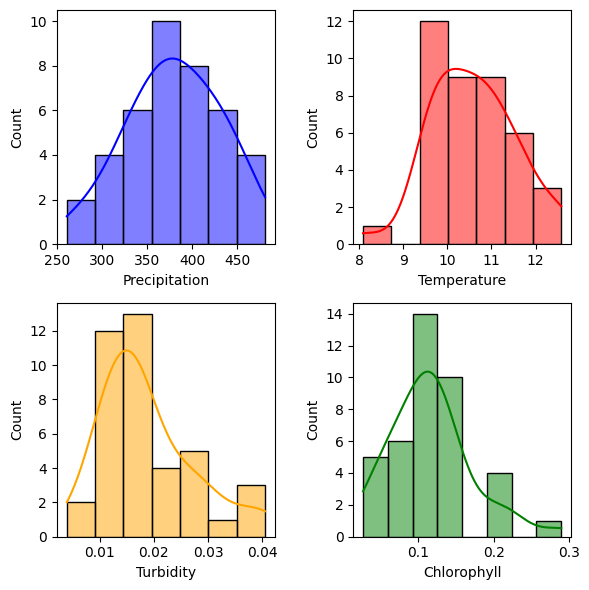

In [ ]:
# Figure: Histograms of variables
plt.figure(figsize=(6, 6))

plt.subplot(2,2,1)
sns.histplot(df['water_prec'], kde=True, color='blue')
# plt.title('Total Precipitation')
plt.xlabel('Precipitation')

plt.subplot(2,2,2)
sns.histplot(df['water_temp'], kde=True, color='red')
# plt.title('Average Temperature')
plt.xlabel('Temperature')

plt.subplot(2,2,3)
sns.histplot(df['water_ndti'], kde=True, color='orange')
# plt.title('Average Turbidity')
plt.xlabel('Turbidity')

plt.subplot(2,2,4)
sns.histplot(df['water_ndci'], kde=True, color='green')
# plt.title('Average Chlorophyll')
plt.xlabel('Chlorophyll')

plt.tight_layout()
plt.savefig('Variable Histograms.jpg', dpi=300)
plt.show()

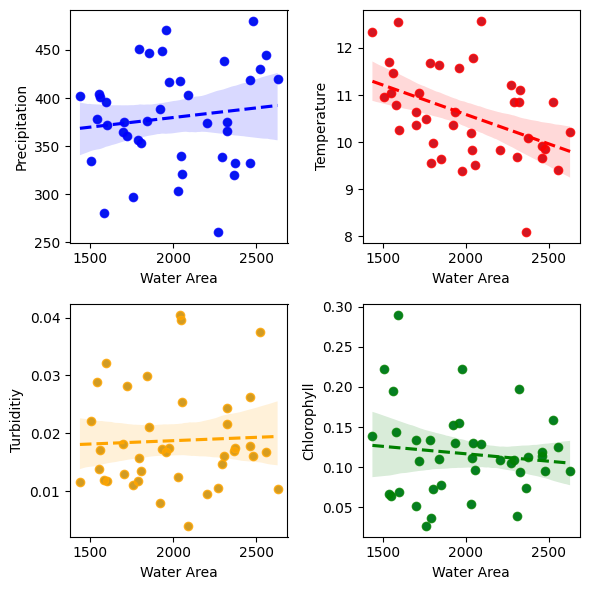

In [ ]:
# Figure: Scatters of Variables
plt.figure(figsize=(6, 6))

plt.subplot(2, 2, 1)
sns.scatterplot(x=df['water_area'], y=df['water_prec'])
sns.regplot(
    x=df['water_area'],
    y=df['water_prec'],
    scatter=True,
    color='blue',
    line_kws={'linestyle': '--'},
    ci=95  # %95 Confidence Interval
)
# plt.title('Water Area-Prec')
plt.xlabel('Water Area')
plt.ylabel('Precipitation')

plt.subplot(2, 2, 2)
sns.scatterplot(x=df['water_area'], y=df['water_temp'])
sns.regplot(
    x=df['water_area'],
    y=df['water_temp'],
    scatter=True,
    color='red',
    line_kws={'linestyle': '--'},
    ci=95  # %95 Confidence Interval
)
# plt.title('Water Area-Temperature')
plt.xlabel('Water Area')
plt.ylabel('Temperature')

plt.subplot(2, 2, 3)
sns.scatterplot(x=df['water_area'], y=df['water_ndti'])
sns.regplot(
    x=df['water_area'],
    y=df['water_ndti'],
    scatter=True,
    color='orange',
    line_kws={'linestyle': '--'},
    ci=95  # %95 Confidence Interval
)
# plt.title('Water Area-Turbiditiy')
plt.xlabel('Water Area')
plt.ylabel('Turbiditiy')

plt.subplot(2, 2, 4)
sns.scatterplot(x=df['water_area'], y=df['water_ndci'])
sns.regplot(
    x=df['water_area'],
    y=df['water_ndci'],
    scatter=True,
    color='green',
    line_kws={'linestyle': '--'},
    ci=95  # %95 Confidence Interval
)
# plt.title('Water Area-Chlorophyll')
plt.xlabel('Water Area')
plt.ylabel('Chlorophyll')

plt.tight_layout()
plt.savefig('Scatter Plot.jpg', dpi=300)
plt.show()

In [ ]:
# %% [markdown]